# Intro to Ophyd & Ophyd-Async

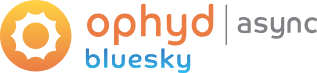

In this tutorial I will try to give you a quick overview of the `ophyd` and `ophyd-async` libraries, explain their purpose in the `bluesky` stack, and show you how to leverage them for integrating disparate hardware components into beamline DAQ.

## What is Ophyd?

Ophyd is an abstraction layer that enables experiment orchestration and data acquisition code to operate above the specifics of particular devices and control systems. In other words ophyd:

**Puts the details specific to a device or control system behind a high-level interface with methods like trigger(), read(), and set(...).**

Another way of thinking of this is that for each device at the beamline, you can probably think of a select few operations that it performs, that you can describe with a verb. For example, 

* Move
* Read
* Trigger
* Locate
...

A motor moves from position A to position B. A temperature controller moves from temperature A to B. While the way the hardware gets told to do this is likely very different, and even the higher level EPICS controls are very different, in a scientific DAQ context we'd prefer it if we could write an experimental routine that could be re-used with both.

Say you have a single axis step scan, where you move a motor to points equidistant to each other, and at each point, you take a reading from a detector. You can write an experimental plan that commands the motor to move to each subsequent point, and asks the detector to trigger and read. Now say your next user wants to use the same detector, but instead of moving a motor, this time the detector remains stationary, and instead your sample stage temperature is ramped by 10 degrees between measurements.

Even though the hardware is very different, from the point of view of a bluesky plan, the above two experiments are equivalent, thanks to the ophyd devices for each physical device abstracting away how a `move` command should be processed by the hardware.

**Groups individual control channels (such as EPICS PVs) into logical "Devices" to be configured and used as units with internal coordination.**

An EPICS IOC provides remote access to a device's functionality over the network. You are probably already familiar with the concept of a Process Variable (PV), which is essentially a named endpoint at which this remote control or monitoring can be performed for a single component of the device. An IOC will typically have many PVs, each of which will control or monitor one feature. For example, on a motor you would have a read-only PV for current position, a read/write PV for commanded position, a read only PV flagging whether the motor is moving or at-rest, etc.

While within the IOC itself there is of course a relationship between all of these PVs, when viewed externally over the network all PVs from all IOCs are accessible together, with only the naming convention for PVs providing any insight into which device each one links to. Thus, the second responsibility of `ophyd` is to provide the interface for grouping all of these independent signals back together at the DAQ code level, so that we can reference our hardware by device, rather than by individual signals.

**Assigns readings with names meaningful for data analysis that will propagate into metadata.**

PV names are often quite long, and not very user friendly. Ophyd allows for re-naming signals to give them more scientifically useful names.

**Categorizes readings by "kind" (primary reading, configuration, engineering/debugging) which can be read selectively.**

During instantiation of a device, you can easily add information to each signal on what it's purpose is, whether it be data, configuration, debugging, etc, so that the DAQ system will immediately know what to do with each one. For example, signals marked as configuration will be read once at the start of a scan and be entered into scan metadata. primary reading signals will be read at each point, and can optionally be used to generate plots or live view tables.

## What is Ophyd-Async?

Ophyd Async is an alternative option to Ophyd that uses asynchronous logic to access the control layer, as well as implementing new features such as EPICS pva access. It also places a larger focus on improved support for flyscannig, with a simpler class inheritance heierarchy, especially for classes for complex file writing detectors.

All of the above capabilities of `ophyd`, are shared by `ophyd-async`, and as long as they are being used through bluesky plans, you can mix and match them, even in the same experimental routine.

## Hands on with Ophyd Sync

Now, let's take a look at some examples!

In [1]:
# First, let's have some imports.

# The Component, Device, and Signal classes are the basic building blocks you will use for Ophyd Sync device implemetnations. Note that when connecting to EPICS PVs, we'll use the EpicsSignal class instead of just Signal
# The Kind class is an enum for tagging signals as primary/config/ignored etc.
from ophyd import Component as Cpt
from ophyd import Device, Kind
from ophyd.signal import Signal

# For the "verbs" I described in the previous section, we can look at bluesky's `Protocols`. These are essentially just abstract classes that when inherited from ensure that your device class supports one of these specific actions.
# for now, let's make a device that we can move.

from bluesky.protocols import Movable

In [2]:
# Now, let's create a new device class.

class MovableDevice(Device, Movable):
    setpoint = Cpt(Signal, name="setpoint", kind=Kind.config)
    readback = Cpt(Signal, name="readback", kind=Kind.hinted)

# Next, let's instantiate a `MovableDevice` object
movable_device = MovableDevice(name="movable_device")

TypeError: Can't instantiate abstract class MovableDevice with abstract method set

Here, I created a class that extends from both `Device` and `Movable`. I also added to it two `Components`, in this case soft signals (signals w/o an EPICS PV behind them), I gave them a relevant name, and I described what their purpose is with the `kind` keyword argument.

However, when I tried to instantiate the device, the instantiation failed. Why is that?

If you look at the error message, you can see that `Python` wants to see a `set` method. The reason for this is that we made `MovableDevice` inherit from `Movable` - which in turn requires that a `set` method is implemented. This then is the standard API for processing the `move` verb that we discussed earlier. OK, so let's update the class with a simple `set`. Note another `ophyd` concept here, one of `Status`-es. A status object in ophyd essentially is used as a way to keep track of a long-running asynchronous operation. Our `set` function will return a status that will keep track of whether or not he move is done. We'll go into more detail on how to use these later, but let's just start with the most basic possible status - a `NullStatus` that instantly marks itself as done.

In [3]:
from ophyd.sim import NullStatus

class MovableDevice(Device, Movable):
    setpoint = Cpt(Signal, name="setpoint", kind=Kind.config)
    readback = Cpt(Signal, name="readback", kind=Kind.hinted)

    def set(self, value):
        print(f"Setting value of {self.name} to {value}")
        return NullStatus()

# Let's try instantiating again
movable_device = MovableDevice(name="movable_device")

In [4]:
print(movable_device)
set_status = movable_device.set(10)
print(set_status.done)
print("=====================================")

MovableDevice(prefix='', name='movable_device', read_attrs=['readback'], configuration_attrs=['setpoint'])
Setting value of movable_device to 10
True


Note that when we `print` our device, it has it's readback and setpoint sorted into read and configuration attributes. This was achieved by assigning a `kind` to each signal in my class. Note that I can call `set` on the device, and this returns a status that is instantly marked as done.

Ok, so now we have a movable device that we can set. However, it doesn't actually set anything, it just returns a null status, so let's change that. We'll use ophyd's `SubscriptionStatus` to watch the value of the readback and compare against the setpoint. We'll also have the `set` method spin up a simple thread that will increment the readback up or down once per second until we reach our setpoint.

In [86]:
# Just like with the verbs, a Status bluesky protocol is available, if a custom status object is required.
# from bluesky.protocols import Status

# Typically though, the ones builtin to ophyd and ophyd-async should be sufficient
from ophyd.status import SubscriptionStatus

# We will spin up a thread to simulate our long asynchronous operation.
# In most real cases, the asynchronous operation is performed by an IOC w/ real hardware.
import time as ttime
import threading

class MovableDevice(Device, Movable):
    setpoint = Cpt(Signal, name="setpoint", kind=Kind.config)
    readback = Cpt(Signal, name="readback", kind=Kind.hinted)
    is_moving = Cpt(Signal, name="is_moving", kind=Kind.omitted)

    # We add an attribute that will store our thread pointer.
    _move_thread: threading.Thread | None = None

    # We are simulating a long asynchronous operation by putting it on a thread here.
    # In most real situations, the asynchronous operation is handled by the EPICS control system.
    def _simulate_move(self):
        while self.setpoint.get() != self.readback.get():
            if abs(self.setpoint.get() - self.readback.get()) <= 1:
                self.readback.set(int(self.setpoint.get()))
            elif self.setpoint.get() > self.readback.get():
                self.readback.set(int(self.readback.get()) + 1)
            else:
                self.readback.set(int(self.readback.get()) - 1)
            ttime.sleep(0.1)
        self.is_moving.set(0)

    def set(self, value) -> SubscriptionStatus | NullStatus:
        # Set the value of our setpoint, and start our move simulation thread
        self.setpoint.set(int(value))

        # If commanded to move to the same position, return an instantly completed null status
        starting_pos = self.readback.get()
        if value == starting_pos:
            return NullStatus()

        self.is_moving.set(1)

        self._move_thread = threading.Thread(target=self._simulate_move)
        self._move_thread.start()

        # The subscription status will take a function as a callback, that will be called with a signal's
        # new value and old value. In this case we are just watching for the new value to see if it is at
        # our setpoint. If it is we cleanup our thread and return true. Otherwise return false indicating
        # that we are not done yet.
        def is_move_done_callback(value, old_value, **kwargs):
            
            if old_value == 1 and value == 0:
                if self._move_thread:
                    self._move_thread.join()
                    self._move_thread = None
                return True
            else:
                return False
            
        return SubscriptionStatus(self.is_moving, is_move_done_callback, run=False, timeout=5)


movable_device = MovableDevice(name="movable_device")

In [87]:
start_time = ttime.time()

move_status = movable_device.set(10)
while not move_status.done:
    print(f"{movable_device.readback = }")
    ttime.sleep(0.1)

print(f"Move done in {ttime.time() - start_time} seconds.")
print("==============================================================")

movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=0.0, timestamp=1746736422.2915888)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=2, timestamp=1746736422.8907957)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=3, timestamp=1746736422.9914732)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=4, timestamp=1746736423.092013)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=5, timestamp=1746736423.1925273)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=6, timestamp=1746736423.2931259)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=7, timestamp=1746736423.3938081)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=

Ok, so now I have a movable device that I can command to certain positions. Next, let's make a device for a detector. We will want it to be triggerable, and readable. We'll follow the same approach as the `Movable` for simulating a long exposure. The `trigger` method (required for supporting the `Triggerable` protocol) also wants a status object returned. We'll make use of the `SubscriptionStatus` again here, but this time we will check both the new and old values - we want to make sure that the status is marked as done when our signal indicating sampling goes from 1 to 0.

In [16]:
# Import the two new protocols we need.
from bluesky.protocols import Triggerable, Readable

# We'll generate random readings for our detector
import random

class DetectorDevice(Device, Triggerable, Readable):

    # Signals typical for a detector - exposure time, sample on/off command, reading
    exposure_time = Cpt(Signal, name="exposure_time", kind=Kind.config)
    sample = Cpt(Signal, name="sample", kind=Kind.omitted)
    point_reading = Cpt(Signal, name="reading", kind=Kind.hinted)

    # Store reference to sampling thread when running
    _sampling_thread: threading.Thread | None = None

    # Simple function to simulate a long exposure. Waits for the given exposure time and produces a random point reading.
    # Then sets our `sample` signal back to zero
    def _simulate_sampling(self):
        exposure_time = self.exposure_time.get()
        ttime.sleep(exposure_time)
        self.point_reading.set(self.exposure_time.get() * random.random() * 10)
        self.sample.set(0)

    # For the Triggerable protocol we need to implement a trigger method that again returns a status object.
    def trigger(self):
        self.sample.set(1)
        self._sampling_thread = threading.Thread(target=self._simulate_sampling)
        self._sampling_thread.start()

        def is_exposure_done_callback(value, old_value, **kwargs):
            if old_value == 1 and value == 0:
                if self._sampling_thread:
                    self._sampling_thread.join()
                    self._sampling_thread = None
                return True
            else:
                return False

        return SubscriptionStatus(self.sample, is_exposure_done_callback, run=False)

    # The Readable protocol requires a describe method that will be called once at the start of the scan to get information
    # about all of the datasets that the device will be responsible for producing. In cases where you are just reading signal information,
    # generally you can just use the read and describe methods already provided by the Device superclass.
    def describe(self):
        return super().describe()

    def read(self):
        return super().read()

detector_device = DetectorDevice(name="detector_device")
print(detector_device.describe())
print("===========================")

OrderedDict([('detector_device_point_reading', {'source': 'SIM:detector_device_point_reading', 'dtype': 'number', 'shape': []})])


Note how the output of `describe` is a dictionary that includes the source, data type, and shape of all of the signals we are interested in, or in other words any signals with `kind` set to `Kind.hinted` or `Kind.normal`. (`Kind.hinted` will additionally be plotted by callbacks.

In [28]:
detector_device.exposure_time.set(0.1) # set exposure time to 1 second.
start_time = ttime.time()
for i in range(5):
    trigger_status = detector_device.trigger()
    while not trigger_status.done:
        pass
    print(detector_device.read())

# Since we took 5 exposures of 1 second each, this should take ~5 seconds
print(f"Taking 5 exposures took {ttime.time() - start_time} seconds")
print("=========================================")

OrderedDict([('detector_device_point_reading', {'value': 0.2545468735819628, 'timestamp': 1746735882.0428665})])
OrderedDict([('detector_device_point_reading', {'value': 0.2152807160029211, 'timestamp': 1746735882.2020357})])
OrderedDict([('detector_device_point_reading', {'value': 0.7473580240043189, 'timestamp': 1746735882.3631809})])
OrderedDict([('detector_device_point_reading', {'value': 0.3307600069955724, 'timestamp': 1746735882.5125847})])
OrderedDict([('detector_device_point_reading', {'value': 0.4400762183320195, 'timestamp': 1746735882.6664693})])
Taking 5 exposures took 0.7830896377563477 seconds


Ok, so now I have a device I can move, and a device I can trigger and read from. So how do I tie these together to run experiments?

This is where bluesky comes in. Since our devices support the appropriate bluesky protocols, we can leverage bluesky plans, the run engine, and callbacks to perform our experiments with our devices.

In [134]:
# Import some of the builtin bluesky plans
from bluesky.plans import scan, count
from bluesky.plan_stubs import mv, mvr

# Import the run engine and best effort callback classes
from bluesky.run_engine import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback

# Create a run engine and create a best effort callback
# The best effort callback will attempt to create live updates via a table and plots as the data is collected.
RE = RunEngine({})
RE.subscribe(BestEffortCallback())

0

In [89]:
# Now, we can perform a move operation, and wait for it to be completed, by calling the run engine.
current_position = movable_device.readback.get()
print(f"Moving {movable_device.name} from {current_position} to {current_position - 5}")
start_time = ttime.time()
RE(mv(movable_device, current_position - 5))
print(f"Move done in {ttime.time() - start_time} seconds.")
print("==============================================================")

Moving movable_device from 10 to 5
Move done in 0.5055739879608154 seconds.


In [90]:
start_time = ttime.time()
print(f"Moving {movable_device.name} by 5 in the positive direction...")
# We could also just use `mvr` to perform a relative movement.
RE(mvr(movable_device, 5))
print(f"Moved {movable_device.name} back to {movable_device.readback.get()} in {ttime.time() - start_time} seconds")

Moving movable_device by 5 in the positive direction...
Moved movable_device back to 10 in 0.5065257549285889 seconds


Similarly, for devices with the `Triggerable` and `Readable` protocols, we can use the `trigger_and_read` bluesky plan stub to take a single reading. The `count` plan will call `trigger_and_read` for a list of detectors a pre-set number of times. Let's try it.



Transient Scan ID: 13     Time: 2025-05-08 16:25:22
Persistent Unique Scan ID: '44bdb093-a1de-4458-9b96-5758c20cc7a7'
New stream: 'primary'
+-----------+------------+-------------------------------+
|   seq_num |       time | detector_device_point_reading |
+-----------+------------+-------------------------------+
|         1 | 16:25:22.3 |                         0.641 |
|         2 | 16:25:22.5 |                         0.989 |
|         3 | 16:25:22.6 |                         0.864 |
|         4 | 16:25:22.8 |                         0.437 |
|         5 | 16:25:22.9 |                         0.975 |
+-----------+------------+-------------------------------+
generator count ['44bdb093'] (scan num: 13)





('44bdb093-a1de-4458-9b96-5758c20cc7a7',)

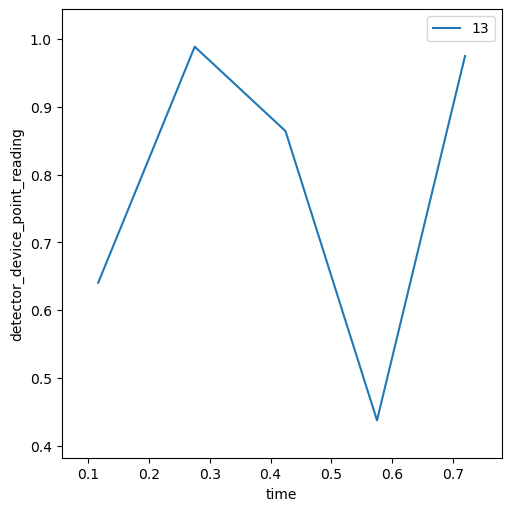

In [61]:
detector_device.exposure_time.set(0.1)
RE(count([detector_device], 5))

Note how we have a nice table printed out for us, along with a graph showing the value for each point in the scan. These are created by the `BestEffortCallback` that we have subscribed the `RunEngine` to. Now, let's try adding in a second detector, and seeing what happens.

In [63]:
detector_device_02 = DetectorDevice(name="detector_device_02")
# Let's set the exposure time for the second detector to two seconds, just to be different.
detector_device_02.exposure_time.set(0.2)

Status(obj=Signal(name='detector_device_02_exposure_time', parent='detector_device_02', value=0.2, timestamp=1746735928.265221), done=False, success=False)



Transient Scan ID: 19     Time: 2025-05-08 16:25:43
Persistent Unique Scan ID: '17a69794-341b-4a47-9cbf-0e3f6bef3958'
New stream: 'primary'
+-----------+------------+-------------------------------+----------------------------------+
|   seq_num |       time | detector_device_point_reading | detector_device_02_point_reading |
+-----------+------------+-------------------------------+----------------------------------+
|         1 | 16:25:43.4 |                         0.931 |                            1.493 |
|         2 | 16:25:43.8 |                         0.142 |                            1.165 |
|         3 | 16:25:44.2 |                         0.705 |                            1.370 |
|         4 | 16:25:44.6 |                         0.126 |                            1.819 |
|         5 | 16:25:45.0 |                         0.692 |                            0.121 |
+-----------+------------+-------------------------------+----------------------------------+
generator co

('17a69794-341b-4a47-9cbf-0e3f6bef3958',)

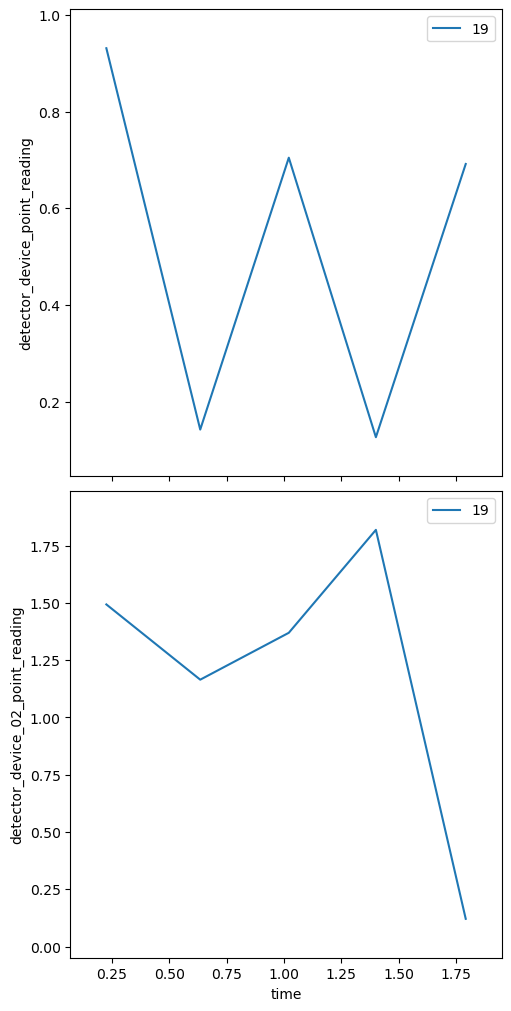

In [69]:
RE(count([detector_device, detector_device_02], 5))

Notice how it takes roughly two tenths of second between each point. This is because the plan is automatically waiting for all detector trigger statuses to be marked as complete before proceeding to the next reading.

Ok, now let's add in our motion. We can perform a simple single axis step scan with the help of the bluesky `scan` plan.



Transient Scan ID: 5     Time: 2025-05-08 16:34:45
Persistent Unique Scan ID: '38a11a95-1e8f-47e0-af58-e85ee4a32de9'
New stream: 'primary'
+-----------+------------+-------------------------+-------------------------------+----------------------------------+
|   seq_num |       time | movable_device_readback | detector_device_point_reading | detector_device_02_point_reading |
+-----------+------------+-------------------------+-------------------------------+----------------------------------+
|         1 | 16:34:47.0 |                       1 |                         0.393 |                            1.711 |
|         2 | 16:34:47.5 |                       2 |                         0.735 |                            0.804 |
|         3 | 16:34:48.0 |                       3 |                         0.659 |                            1.457 |
|         4 | 16:34:48.5 |                       4 |                         0.595 |                            0.439 |
|         5 | 16:34

('38a11a95-1e8f-47e0-af58-e85ee4a32de9',)

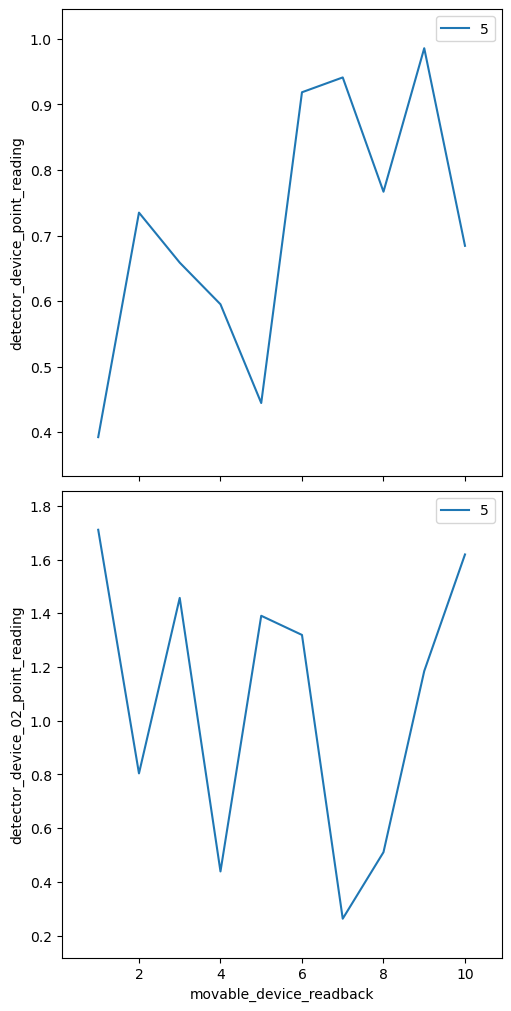

In [95]:
RE(scan([detector_device, detector_device_02], movable_device, 1, 10, 10))

Ok, let's add in a second movable, and try a grid scan.

In [97]:
from bluesky.plans import grid_scan

movable_device_02 = MovableDevice(name="movable_device_02")
RE(mv(movable_device_02, 15))

()



Transient Scan ID: 6     Time: 2025-05-08 16:35:03
Persistent Unique Scan ID: '2c8dbbaa-afe8-478e-a727-2b06437233d4'
New stream: 'primary'
+-----------+------------+-------------------------+----------------------------+-------------------------------+----------------------------------+
|   seq_num |       time | movable_device_readback | movable_device_02_readback | detector_device_point_reading | detector_device_02_point_reading |
+-----------+------------+-------------------------+----------------------------+-------------------------------+----------------------------------+
|         1 | 16:35:05.3 |                       0 |                          0 |                         0.571 |                            1.679 |
|         2 | 16:35:06.0 |                       0 |                          1 |                         0.750 |                            1.106 |
|         3 | 16:35:06.7 |                       0 |                          2 |                         0.308 | 

('2c8dbbaa-afe8-478e-a727-2b06437233d4',)

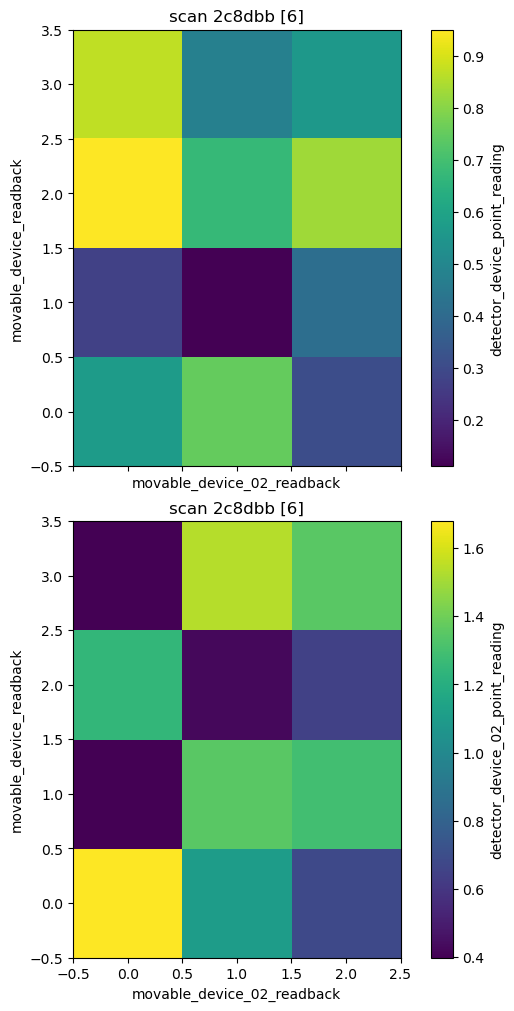

In [98]:
RE(grid_scan([detector_device, detector_device_02], movable_device, 0, 3, 4, movable_device_02, 0, 2, 3, snake_axes = True))

Notice how the best effort callback was able to interpret that we performed a 2D scan, and plotted our point detector data accordingly. Also, going back to the reasoning behind these high level protocols/verbs in ophyd - the `grid_scan` plan takes any `Triggerable/Readable` devices in the list of detectors, and any `Movable` devices as arguments for the inner and outer axes. If you implement a temperature controller as a `Movable` ophyd device for example, you can do a grid scan where your outer axis is the temperature, and your inner axis is a physical motor. In this example, you could ramp temperature by increments of 5 degrees, and perform a single axis step scan at each temperature value.

One other thing to note with the grid scan is you are not limited to two axes. I could add any number of movables, and the plan will navigate to all the permutations associated with these.

Ok, now how about if I have a compound device. For example, I have a multi-axis stage, and I want to be able to give it a single value and have all the axes move at once. I can do this by making a higher level `Movable` `Device`, with `MovableDevice` components.

In [ ]:
import math

class TwoJackStage(Device, Movable):
    upstream = Cpt(MovableDevice, name="upstream")
    downstream = Cpt(MovableDevice, name="downstream")
    pitch = Cpt(Signal, name="pitch", kind=Kind.hinted)

    def __init__(self, distance_between_jacks, d_pivot_from_upstream, *args, **kwargs):
        self._distance_between_jacks = distance_between_jacks
        self._frac_pivot_to_upstream = d_pivot_from_upstream / self._distance_between_jacks
        self._frac_pivot_to_downstream = (distance_between_jacks - d_pivot_from_upstream) / self._distance_between_jacks
        super().__init__(*args, **kwargs)
    
    def set(self, value):
        # We will set a value in degrees, extract upstream and downstream positions, and request our components to move.
        # We assume the pivot point is exactly in the middle of the two axes, which are spaced 10 units apart.

        if value > 70 or value < -70:
            raise ValueError(f"Value {value} is outside of the permitted range: -70 to 70!")

        self.pitch.set(value)

        rad = math.radians(value)
        upstream_val = int(-math.tan(rad) * self._distance_between_jacks * self._frac_pivot_to_upstream)
        downstream_val = int(math.tan(rad) * self._distance_between_jacks * self._frac_pivot_to_downstream) 

        upstream_status = self.upstream.set(upstream_val)
        downstream_status = self.downstream.set(downstream_val)
        
        # In ophyd sync, you can simply `&` to status objects together to produce a special `AndStatus` object.
        return upstream_status & downstream_status

two_jack_stage = TwoJackStage(10, 3, name="two_jack_stage")
two_jack_stage.read()

OrderedDict([('two_jack_stage_upstream_readback',
              {'value': 0.0, 'timestamp': 1746738520.174892}),
             ('two_jack_stage_downstream_readback',
              {'value': 0.0, 'timestamp': 1746738520.174951}),
             ('two_jack_stage_pitch',
              {'value': 0.0, 'timestamp': 1746738520.1749775})])

Notice how this compound device's `read` (and `describe`) will include `hinted` signals from it's sub-components - in this case the `readback` signal from our two `MovableDevice` components.

Also, notice how I didn't add the `read` method (or the `Readable` protocol even!), and yet I can still call it. This is because the `Device` class we are inheriting from implements this method for us already, among others. Also, the `bluesky` protocols, have a feature that makes them `runtime_checkable`, meaning that even for objects that didn't explicitly inherit from them, you can call `isinstance(obj, Readable)` for example. Thus, adding the protocols to your class definition is not strictly necessary in most cases - however, in my opinion it is well worth doing - it will quickly catch issues where there is a missing method for your class.

Let's run a scan with one of our detectors, and our compound device, and see what happens.



Transient Scan ID: 12     Time: 2025-05-08 17:08:47
Persistent Unique Scan ID: '69b7ac93-fde6-4c61-9b4f-1fca70167256'
New stream: 'primary'
+-----------+------------+----------------------------------+------------------------------------+----------------------+-------------------------------+
|   seq_num |       time | two_jack_stage_upstream_readback | two_jack_stage_downstream_readback | two_jack_stage_pitch | detector_device_point_reading |
+-----------+------------+----------------------------------+------------------------------------+----------------------+-------------------------------+
|         1 | 17:08:47.7 |                            0.000 |                              0.000 |                0.000 |                         0.720 |
|         2 | 17:08:47.9 |                            0.000 |                              1.000 |               10.000 |                         0.781 |
|         3 | 17:08:48.2 |                           -1.000 |                           

('69b7ac93-fde6-4c61-9b4f-1fca70167256',)

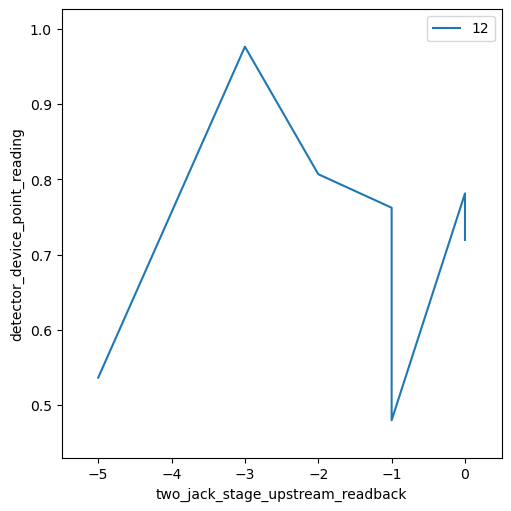

In [112]:
RE(scan([detector_device], two_jack_stage, 0, 60, 7))

Again, notice how our compound device's components have their `hinted` signals propagate to our visualization courtesy of our `BestEffortCallback`. Also, note that our simple simulation movable can only be set to integer values, so our angle positions are approximations. Of course, with real motors you would have higher precision.

Next, let's try doing something similar for our detector.

In [122]:
class FourChannelDet(Device):
    ch1 = Cpt(DetectorDevice, name="ch1")
    ch2 = Cpt(DetectorDevice, name="ch2")
    ch3 = Cpt(DetectorDevice, name="ch3")
    ch4 = Cpt(DetectorDevice, name="ch4")
    exposure_time = Cpt(Signal, name="exposure_time", kind=Kind.config)

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Since we are setting exposure time at the parent level, no need to keep track of it for each channel.
        self.ch1.exposure_time.kind = Kind.omitted
        self.ch2.exposure_time.kind = Kind.omitted
        self.ch3.exposure_time.kind = Kind.omitted
        self.ch4.exposure_time.kind = Kind.omitted

    # Here is a new concept - stage.
    # Stage is ran once at the start of each plan, and unstage is ran once at the end.
    # If you have a device that you want set up a certain way for every scan, but put back to something else 
    def stage(self):
        exp_time = self.exposure_time.get()
        self.ch1.exposure_time.set(exp_time)
        self.ch2.exposure_time.set(exp_time)
        self.ch3.exposure_time.set(exp_time)
        self.ch4.exposure_time.set(exp_time)
        super().stage()

    def trigger(self):
        ch1_trig_stat = self.ch1.trigger()
        ch2_trig_stat = self.ch2.trigger()
        ch3_trig_stat = self.ch3.trigger()
        ch4_trig_stat = self.ch4.trigger()
        return ch1_trig_stat & ch2_trig_stat & ch3_trig_stat & ch4_trig_stat


four_channel_det = FourChannelDet(name="four_ch_det")



Transient Scan ID: 15     Time: 2025-05-08 17:46:12
Persistent Unique Scan ID: 'fe941df7-6d18-4c72-9559-9bcccd4101ec'
New stream: 'primary'
+-----------+------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|   seq_num |       time | four_ch_det_ch1_point_reading | four_ch_det_ch2_point_reading | four_ch_det_ch3_point_reading | four_ch_det_ch4_point_reading |
+-----------+------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|         1 | 17:46:12.5 |                         0.016 |                         0.939 |                         0.648 |                         0.466 |
|         2 | 17:46:13.4 |                         0.383 |                         0.323 |                         0.862 |                         0.767 |
|         3 | 17:46:14.3 |                         0.384 |                         

('fe941df7-6d18-4c72-9559-9bcccd4101ec',)

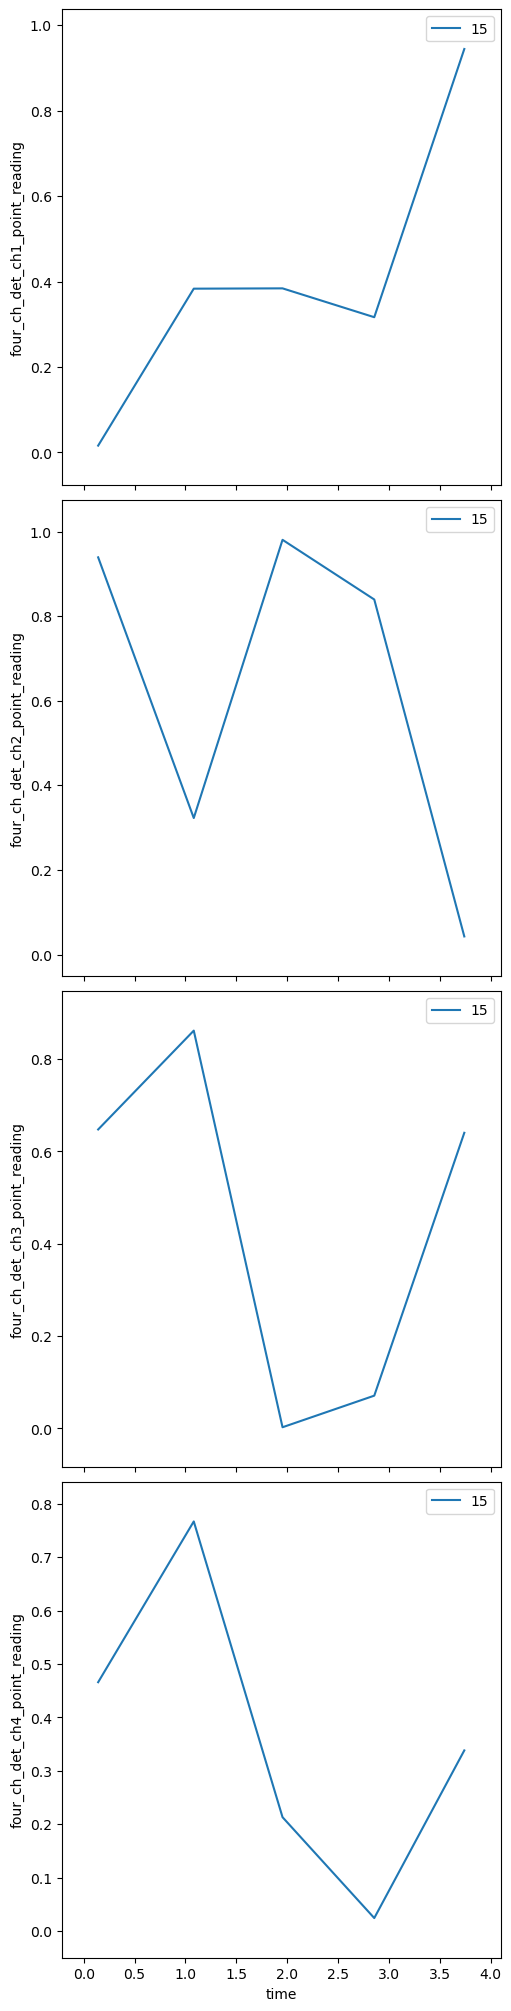

In [123]:
four_channel_det.exposure_time.set(0.1)
RE(count([four_channel_det], 5))

Now, let's take a look at exactly what is happening when we run a scan that lets us visualize the data.

Let's start by unsubscribing the `BestEffortCallback` from the `RE`, and subscribing instead to a super simple callback, that will just print out what is being sent to all our subscriptions.

In [135]:
RE.unsubscribe(0)

import json

# An RE subscription is just a callable that takes two arguments - a name and a document (dictionary that follows bluesky's event model schema).
def printout_docs(name: str, doc: dict):
    print(f"=============== {name} ==============")
    print(json.dumps(doc, indent=4))
    print("=======================================")

RE.subscribe(printout_docs)

1

In [136]:
RE(scan([detector_device], two_jack_stage, 0, 20, 3))

=============== start ==============
{
    "uid": "1655ced2-09e4-470e-9358-075eb2d35417",
    "time": 1746741227.0896554,
    "versions": {
        "ophyd": "1.9.0",
        "bluesky": "1.13.0a3"
    },
    "scan_id": 1,
    "plan_type": "generator",
    "plan_name": "scan",
    "detectors": [
        "detector_device"
    ],
    "motors": [
        "two_jack_stage"
    ],
    "num_points": 3,
    "num_intervals": 2,
    "plan_args": {
        "detectors": [
            "DetectorDevice(prefix='', name='detector_device', read_attrs=['point_reading'], configuration_attrs=['exposure_time'])"
        ],
        "num": 3,
        "args": [
            "TwoJackStage(prefix='', name='two_jack_stage', read_attrs=['upstream', 'upstream.readback', 'downstream', 'downstream.readback', 'pitch'], configuration_attrs=['upstream', 'upstream.setpoint', 'downstream', 'downstream.setpoint'])",
            0,
            20
        ],
        "per_step": "None"
    },
    "hints": {
        "dimensions":

('1655ced2-09e4-470e-9358-075eb2d35417',)

You can see that what was produced was a `start` document in the beginning, which contains a scan ID, scan metadata, and some other relevant per-scan info. Then, the `descriptor` includes our configuration signals and their readings (once per scan), along with descriptions of the datasets we will be producing during our individual readings.

Then come our `event` documents, which contain our individual readings from our motors and detectors. Finally, comes the `stop` document, which tells us if the scan succeeded or not, a run time, etc. The `BestEffortCallback` we were using for visualization before receives these same documents, and knows how to interpret them and use the included information to plot our data.

At this point we've covered a lot of the basics. From here on out we will switch to some live (slightly more complex) examples that I will walk through using some test equipment we have in the lab. I'll also demonstrate creating some devices using `ophyd_async` as well.

At a beamline, you will typically be able to use a pre-exisiting library of ophyd devices in a lot of cases. Most notably, for motors there is the `EpicsMotor` class, and an equivalent one in `ophyd_async`. Likewise, `areaDetector` based detectors have fairly mature `ophyd` device classes in both sync and async variants that you can import and instantiate. Many of the other commonly used devices at our beamlines also have ophyd devices already constructred, and you can often find examples in beamline profile collection repositories.

That being said, using these pre-built devices you can create more complex ones just like what we did with these simple examples. For example, you can create a compound device made up of several EPICS motors that corresponds to monochromater energy

Let's switch over to a live-coding session where I'll try to demonstrate some of what we went through in-practice.